# Modele uczenia maszynowego


Do wygenerowania kodów użyjemy biblioteki PyTorch

## Regresja liniowa

Wygenerujemy niezaszumione dane na podstawie wzoru $y = 2 x - 1$. 
Na podstawie zbioru danych postaramy się oszacować nieznane parametry czyli wyraz przy $x$ ($\alpha_1 = 2$) i wyraz wolny ($\alpha_0 = -1$).

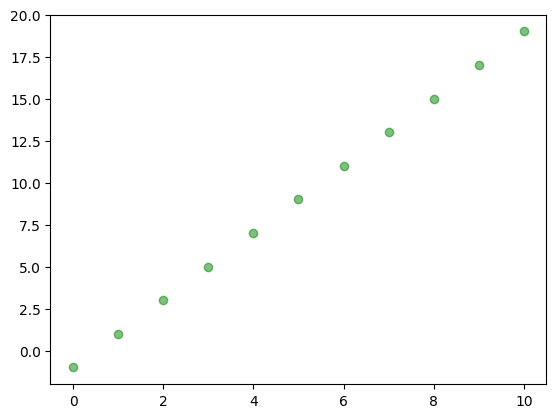

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# zbior danych
x = range(11)
y = [2*xi - 1 for xi in x]
plt.plot(x, y, 'go', label='True data', alpha=0.5)

Model regresji liniowej dla jednej zmiennej można zrealizować jako prostą jednowarstwową sieć neuronową. 
Cały proces można zrealizować za pomocą obiektu `torch.nn.Linear`

In [3]:
import torch

class LinearRegression(torch.nn.Module):

    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputSize, outputSize)
        ) 
        
    def forward(self, x):
        return self.layers(x)

In [4]:
m = torch.nn.Linear(1,1)

In [5]:
m

Linear(in_features=1, out_features=1, bias=True)

In [6]:
m.weight, m.bias

(Parameter containing:
 tensor([[-0.1154]], requires_grad=True),
 Parameter containing:
 tensor([0.4927], requires_grad=True))

Aby nasze dane mogłybyć przeliczane przez bibliotekę PyTorch musimy je przetworzyć na tensory - czyli obiekty z biblioteki PyTorch.

In [7]:
# dostosowanie do pytorch
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X_train = torch.from_numpy(x).view(-1,1)
y_train = torch.from_numpy(y).view(-1,1)

Uwaga - ponieważ mamy jedną zmienną zawierającą 10 przypadków - potrzebujemy listy składającej się z 10 list jednoelementowych.

Mozna tez wykorzystac obiektowe programowanie. 

In [8]:
from torch.utils.data import Dataset, DataLoader

class LinearDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train # tensor typu torch
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [9]:
dataset = LinearDataset(X_train=X_train, y_train=y_train)

In [10]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=2)

Możemy utworzyć model i wybrać optymalizator z funkcją kosztu. 

In [11]:
# obiekt liniowej regresji w wersji sieci nn
lr_model = LinearRegression(1,1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)

Możemy sprawdzić, że nasz model będzie dostrajał 2 parametry.

In [12]:
num_params = sum(p.numel() for p in lr_model.parameters() if p.requires_grad)
print(f"liczba trenowalnych parametrów: {num_params}")

liczba trenowalnych parametrów: 2


Parametry te w początkowej inicjalizacji mają następujące wartości:

In [13]:
for layer in lr_model.layers:
    if isinstance(layer, torch.nn.Linear):
        print(f"weight: {layer.state_dict()['weight']}")
        print(f"bias: {layer.state_dict()['bias']}")

weight: tensor([[0.7394]])
bias: tensor([0.1832])


In [14]:
epochs = 400
# petla uczaca 
for epoch in range(epochs):
    lr_model.train() # etap trenowania 

    y_pred = lr_model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'epoch: {epoch+1:03d}, loss = {loss.item():.4f}')
 
    lr_model.eval() # etap ewaluacji modelu

# po treningu jeszcze raz generujemy predykcje
lr_model.eval()
with torch.no_grad():
    predicted = lr_model(X_train)

epoch: 050, loss = 0.2946
epoch: 100, loss = 0.1681
epoch: 150, loss = 0.0959
epoch: 200, loss = 0.0547
epoch: 250, loss = 0.0312
epoch: 300, loss = 0.0178
epoch: 350, loss = 0.0101
epoch: 400, loss = 0.0058


Mozna tez wykorzystac obiekt `dataloader`

In [15]:
for epoch in range(50):
    for X_batch, y_batch in dataloader:
        preds = lr_model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.4f}")

Epoch 0, loss = 0.0060
Epoch 10, loss = 0.0046
Epoch 20, loss = 0.0000
Epoch 30, loss = 0.0014
Epoch 40, loss = 0.0001


Otrzymane parametry po uczeniu 

In [16]:
print(f"po procesie uczenia waga: {lr_model.layers[0].weight} oraz bias {lr_model.layers[0].bias}")

po procesie uczenia waga: Parameter containing:
tensor([[1.9952]], requires_grad=True) oraz bias Parameter containing:
tensor([-0.9755], requires_grad=True)


Dopasowanie modelu do danych można przedstawić na wykresie

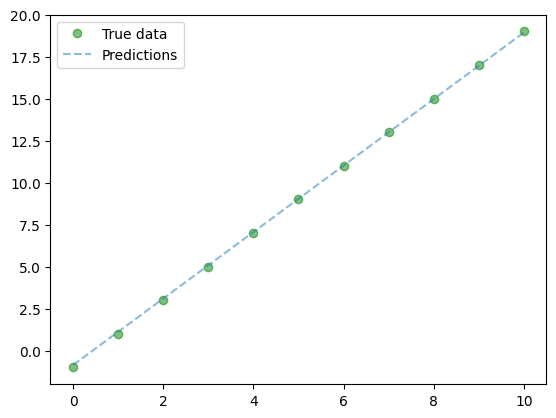

In [17]:
plt.clf()
plt.plot(X_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(X_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

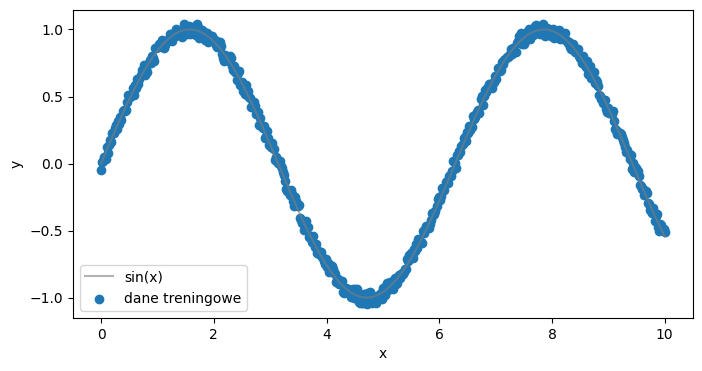

In [18]:
import torch
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output

torch.manual_seed(1234)

# DANE 
x = torch.linspace(0,10,500).view(-1,1)
y = torch.sin(x)
y = y + 0.1*(torch.rand(500).view(-1,1)-0.5)

plt.figure(figsize=(8,4))
plt.plot(x, torch.sin(x).view(-1,1), color="tab:grey", alpha=0.6, label="sin(x)")
plt.scatter(x,y, label="dane treningowe")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [19]:
class SinusEstimator(torch.nn.Module):

    def __init__(self, N_INPUT: int, N_OUTPUT: int):
        super(SinusEstimator,self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(N_INPUT, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,16),
            torch.nn.Tanh(),
            torch.nn.Linear(16,N_OUTPUT)
        )


    def forward(self, x):
        x = self.layers(x)
        return x

model = SinusEstimator(1,1)

learning_rate=0.001
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

losses = []


In [20]:
def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="Classical solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()



In [21]:

def train(X,Y, model, optimiser, epochs, lossfn, callback = None):
    for epoch in range(epochs):
        model.train()
        prediction = model(X)
        loss = lossfn(prediction, Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        model.eval()
        if callback != None:
            callback(model, loss)

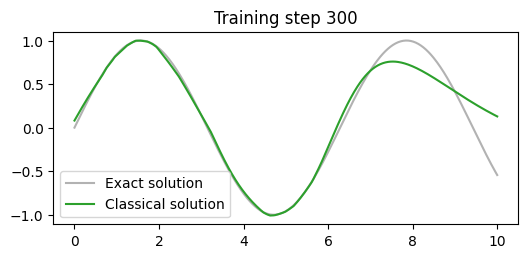

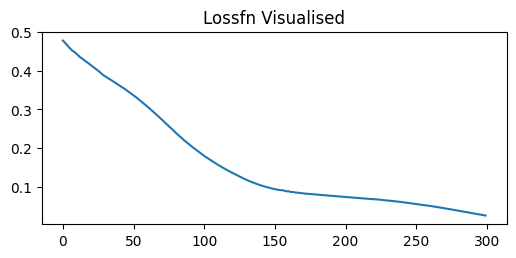

In [22]:
x_train = x.requires_grad_(False)

train(x_train, y, model, optimiser, 300, criterion, callback)

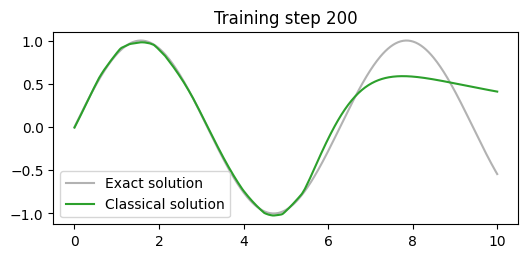

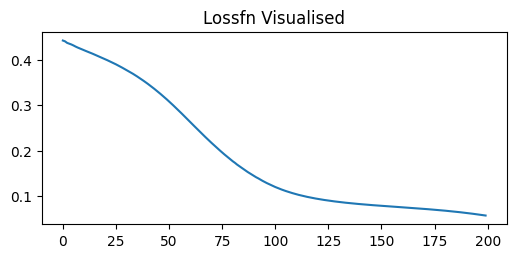

In [23]:
def mse(y, y_pred) -> torch.Tensor:
    return torch.mean((y-y_pred)**2)

def special_loss_fn(y, y_pred) -> torch.Tensor:
    return mse(y, y_pred) + torch.mean((y_pred - torch.sin(x))**2)

model2 = SinusEstimator(1,1)

learning_rate=0.001
optimiser = torch.optim.Adam(model2.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
losses = []

train(x_train, y, model2, optimiser, 200, special_loss_fn, callback)

## Regresja logistyczna

W przypadku procesu klasyfikacji danych do numerycznego wyniku musimy dodać funkcję aktywacji - sigmoid $\sigma$, która pozwoli nam wygenerować prawdopodobieństwo otrzymania klasy 1. 

Dane wygenerujemy na podstawie pakietu scikit-learn 

In [23]:
from sklearn.datasets import make_classification
import numpy as np

# prepare dataset
X, y = make_classification(n_samples=10**4, n_features=10 ,random_state=42)

In [24]:
import torch

class LogisticRegression(torch.nn.Module):

    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputSize, outputSize),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

Podobnie jak w przypadku regresji liniowej musimy przetworzyć nasze dane do obiektów torch. 

In [25]:
X_train = torch.from_numpy(X.astype(np.float32))
y_train = torch.from_numpy(y.astype(np.float32))
y_train = y_train.view(y_train.shape[0], 1)

In [26]:
model = LogisticRegression(X_train.shape[1], y_train.shape[1])

learningRate = 0.01
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# petla uczaca 
num_epochs = 500

for epoch in range(num_epochs):
    # forward pass and loss
    model.train()
    y_predicted = model(X_train)
    loss = criterion(y_predicted, y_train)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    model.eval()

    if (epoch+1) % 50 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')



model.eval()
with torch.no_grad():
    y_predicted = model(X_train)  # no need to call model.forward()
    y_predicted_cls = y_predicted.round()   # round off to nearest class
    acc = y_predicted_cls.eq(y_train).sum() / float(y_train.shape[0])  # accuracy
    print(f'accuracy = {acc:.4f}')
    print(f"predykcja dla wiersza 0:{y_predicted[0]}, wartosc prawdziwa: {y_train[0]}")

epoch: 50, loss = 0.6307
epoch: 100, loss = 0.5104
epoch: 150, loss = 0.4487
epoch: 200, loss = 0.4120
epoch: 250, loss = 0.3878
epoch: 300, loss = 0.3708
epoch: 350, loss = 0.3581
epoch: 400, loss = 0.3484
epoch: 450, loss = 0.3406
epoch: 500, loss = 0.3343
accuracy = 0.8830
predykcja dla wiersza 0:tensor([0.8189]), wartosc prawdziwa: tensor([1.])
